In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/BaiKiemTra/21022008/dataset/images

/content/drive/MyDrive/BaiKiemTra/21022008/dataset/images


In [3]:
!ls

cat  dog


In [4]:
# !unzip /content/drive/MyDrive/BaiKiemTra/21022008.zip

In [5]:
# THIẾT LẬP CÁC THAM SỐ

import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = "/content/drive/MyDrive/BaiKiemTra/21022008/dataset"
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])

In [6]:
IMAGES_PATH

'/content/drive/MyDrive/BaiKiemTra/21022008/dataset/images'

In [7]:
# define the path to the base output directory
BASE_OUTPUT = "/content/drive/MyDrive/BaiKiemTra/21022008/output"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "21022008_model.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "lb.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])

In [8]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-3      # Tốc độ học
NUM_EPOCHS = 50
BATCH_SIZE = 16

In [9]:
# HUẤN LUYỆN MÔ HÌNH
## Import thư viện
# import the necessary packages
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [10]:
## Load dữ liệu

# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [11]:
ANNOTS_PATH

'/content/drive/MyDrive/BaiKiemTra/21022008/dataset/annotations'

In [12]:
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(ANNOTS_PATH, validExts=(".csv")):
	# load the contents of the current CSV annotations file
	rows = open(csvPath).read().strip().split("\n")
	# loop over the rows
	for row in rows:
		# break the row into the filename, bounding box coordinates,
		# and class label
		row = row.split(",")
		(filename, label, startX, startY, endX, endY) = row
		# derive the path to the input image, load the image (in
		# OpenCV format), and grab its dimensions
		imagePath = os.path.sep.join([IMAGES_PATH, label, filename+'.jpg'])
		image = cv2.imread(imagePath)
		(h, w) = image.shape[:2]
		# scale the bounding box coordinates relative to the spatial
		# dimensions of the input image
		startX = float(startX) / w
		startY = float(startY) / h
		endX = float(endX) / w
		endY = float(endY) / h
		# load the image and preprocess it
		image = load_img(imagePath, target_size=(224, 224))
		image = img_to_array(image)
		# update our list of data, class labels, bounding boxes, and
		# image paths
		data.append(image)
		labels.append(label)
		bboxes.append((startX, startY, endX, endY))
		imagePaths.append(imagePath)

In [13]:
imagePath

'/content/drive/MyDrive/BaiKiemTra/21022008/dataset/images/dog/dogs_099.jpg'

In [14]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

In [15]:
# Phân chia dữ liệu

split = train_test_split(data, labels, bboxes, imagePaths,test_size=0.1, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [16]:
# Xây dựng mô hình
cnn = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
cnn.trainable = False
flatten = cnn.output
flatten = Flatten()(flatten)

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name="bounding_box")(bboxHead)

# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax",name="class_label")(softmaxHead)

# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(inputs=cnn.input,outputs=(bboxHead, softmaxHead))

In [17]:
# Xác định loss và compile mô hình

losses = {"class_label": "categorical_crossentropy","bounding_box": "mean_squared_error",}
lossWeights = {	"class_label": 1.0,	"bounding_box": 1.0}

# summary
opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [18]:
## Huấn luyện mô hình*

trainTargets = {"class_label": trainLabels,"bounding_box": trainBBoxes}
testTargets = {	"class_label": testLabels,"bounding_box": testBBoxes}

In [19]:
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

# serialize the model to disk
print("[INFO] saving object detector model...")
model.save(MODEL_PATH, save_format="h5")

# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] training model...
Epoch 1/50
13/13 [==============================] - 18s 389ms/step - loss: 4.1510 - bounding_box_loss: 0.0690 - class_label_loss: 4.0820 - bounding_box_accuracy: 0.2740 - class_label_accuracy: 0.8413 - val_loss: 2.2032 - val_bounding_box_loss: 0.0516 - val_class_label_loss: 2.1516 - val_bounding_box_accuracy: 0.2917 - val_class_label_accuracy: 0.9583
Epoch 2/50
13/13 [==============================] - 1s 63ms/step - loss: 1.2589 - bounding_box_loss: 0.0569 - class_label_loss: 1.2020 - bounding_box_accuracy: 0.2740 - class_label_accuracy: 0.9567 - val_loss: 0.0516 - val_bounding_box_loss: 0.0516 - val_class_label_loss: 4.9671e-09 - val_bounding_box_accuracy: 0.2917 - val_class_label_accuracy: 1.0000
Epoch 3/50
13/13 [==============================] - 1s 64ms/step - loss: 0.4555 - bounding_box_loss: 0.0569 - class_label_loss: 0.3986 - bounding_box_accuracy: 0.2740 - class_label_accuracy: 0.9808 - val_loss: 0.0516 - val_bounding_box_loss: 0.0516 - val_class_label_

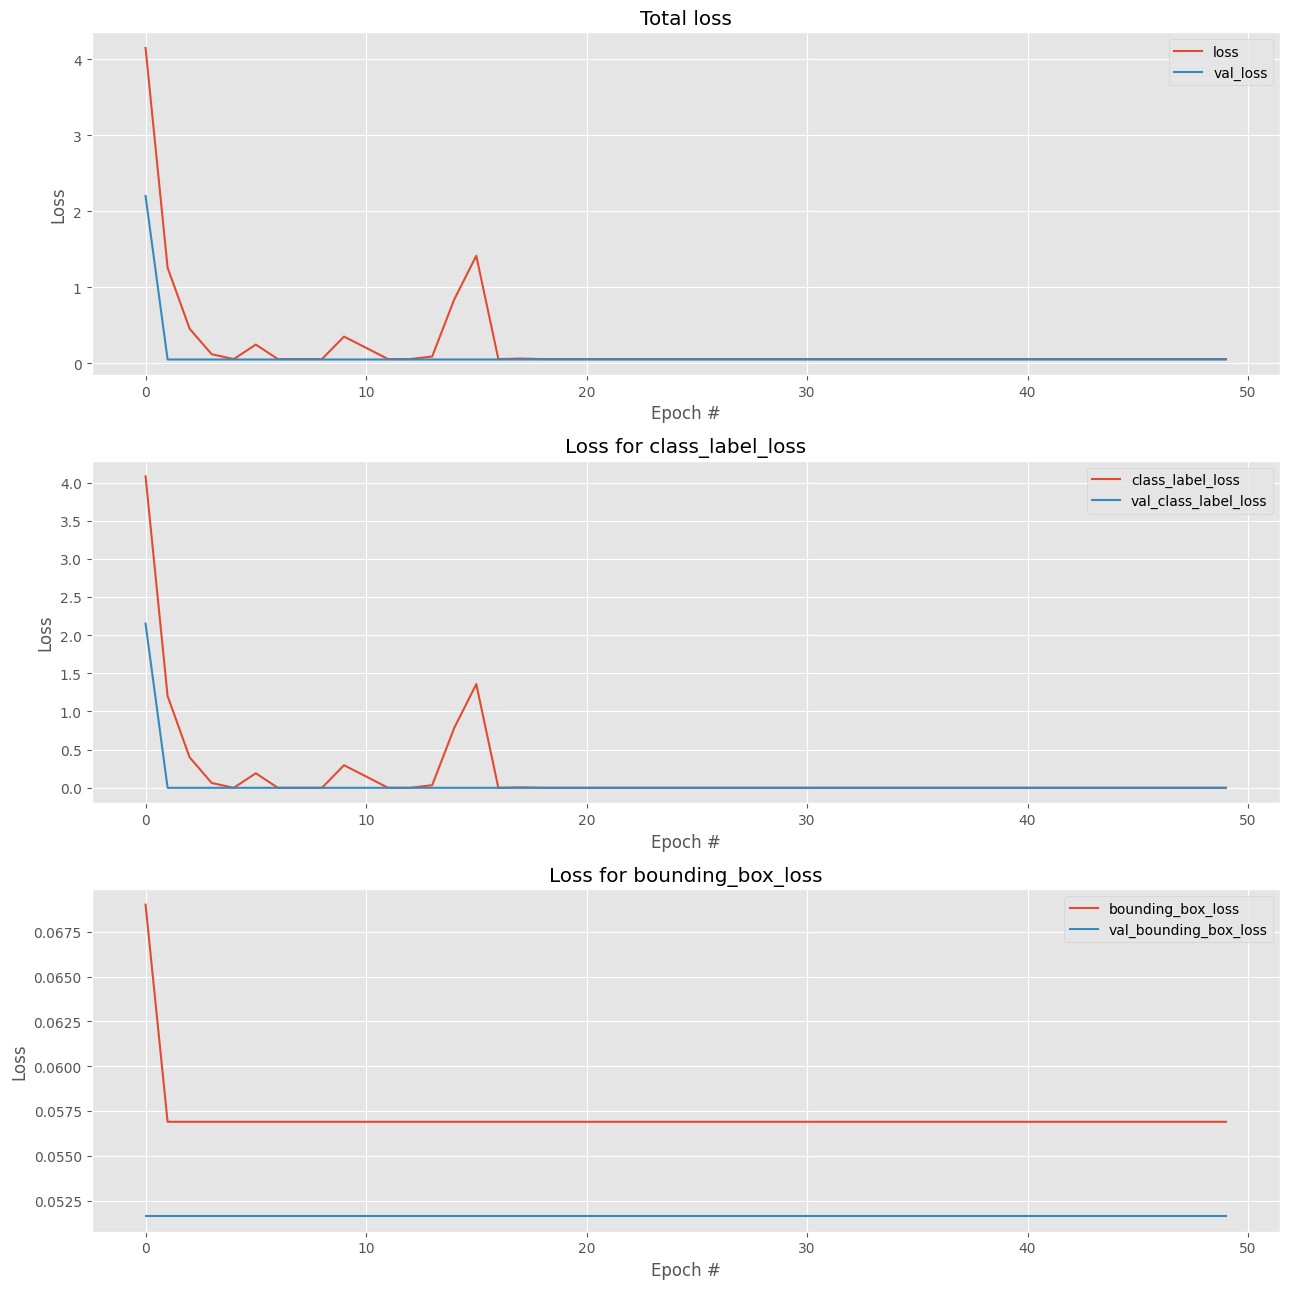

In [20]:
# Hiển thị loss và accuracy

# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

# save the losses figure and create a new figure for the accuracies
# Tạo ra thư mục nếu nó chưa tồn tại
if not os.path.exists(PLOTS_PATH):
    os.makedirs(PLOTS_PATH)

plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "21022008_Loss.png"])
plt.savefig(plotPath)
# plt.close()

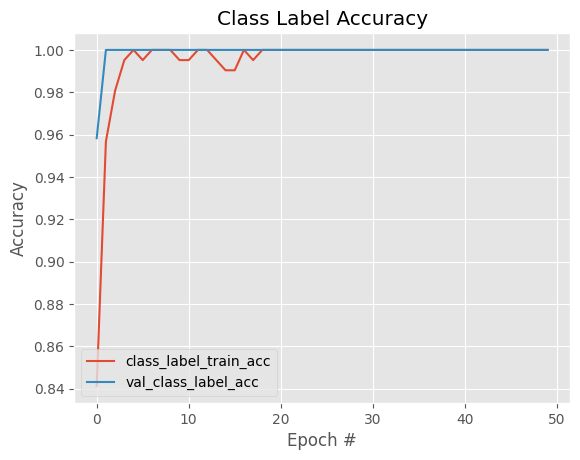

In [21]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "21022008_Acc.png"])
plt.savefig(plotPath)

1/1 [==============================] - 0s 48ms/step


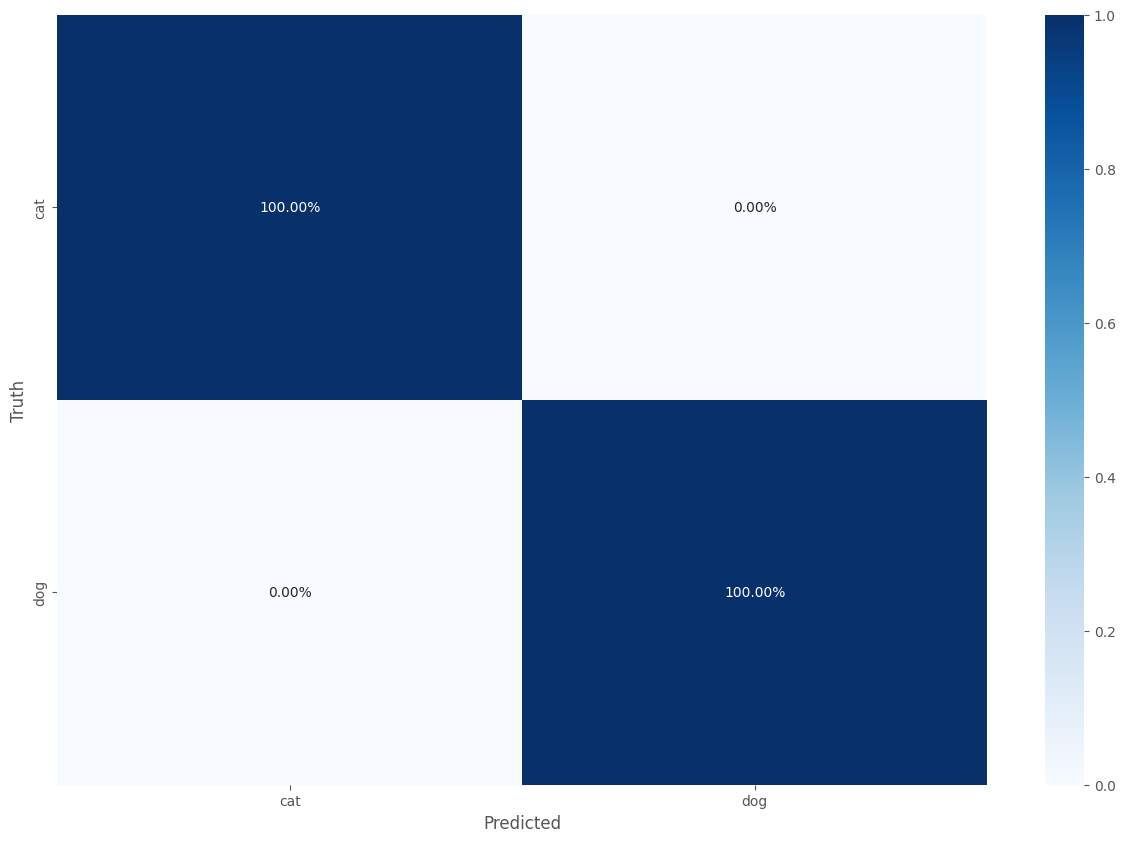

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get class names from the LabelBinarizer
class_names = lb.classes_

# Create the confusion matrix as before
Y_pred = model.predict(testImages)
Y_pred_classes = np.argmax(Y_pred[1], axis=1)
Y_true = np.argmax(testTargets["class_label"], axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]

# When calling heatmap, pass class names to the xticklabels and yticklabels arguments
plt.figure(figsize=(15,10))
sns.heatmap(confusion_mtx_percent, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

1/1 [==============================] - 0s 34ms/step


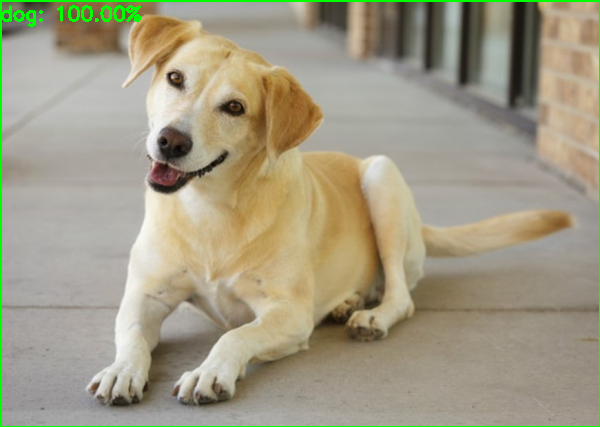

In [30]:
from google.colab.patches import cv2_imshow
from imutils import paths
import imutils

# path_img_test = '/content/drive/MyDrive/BaiKiemTra/21022008/image1.jpg'
path_img_test = '/content/drive/MyDrive/BaiKiemTra/21022008/image2.jpg'

image = load_img(path_img_test, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Thực hiện dự đoán hình ảnh với mô hình
(boxPreds, labelPreds) = model.predict(image)

# Lấy tọa độ hộp giới hạn dự đoán
(startX, startY, endX, endY) = boxPreds[0]

# Tải lại hình ảnh và điều chỉnh kích thước
image = cv2.imread(path_img_test)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# Tính toán tọa độ hộp giới hạn dựa trên dự đoán
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)

# Chọn nhãn và xác suất dự đoán cao nhất
i = np.argmax(labelPreds, axis=1)
label = lb.classes_[i][0]
confidence = np.max(labelPreds)

# Tạo nhãn với xác suất dự đoán
label_with_confidence = "{}: {:.2f}%".format(label, confidence * 100)

# Vẽ hộp giới hạn và nhãn
cv2.putText(image, label_with_confidence, (startX, startY + 20), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)

# Hiển thị hình ảnh
cv2_imshow(image)